<a href="https://colab.research.google.com/github/Raef88/RFdiffusion/blob/main/af/examples/af_cyc_design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#af_cyc_design

**Cyclic peptide structure prediction and design using AlphaFold**

Stephen Rettie, Katelyn Campbell, Asim Bera, Alex Kang, Simon Kozlov, Joshmyn De La Cruz, Victor Adebomi, Guangfeng Zhou, Frank DiMaio, Sergey Ovchinnikov, Gaurav Bhardwaj

doi: https://doi.org/10.1101/2023.02.25.529956


In [1]:
#@title setup (~2 minutes)
%%time
import os
if not os.path.isdir("params"):
  # get code
  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@v1.1.1")
  # for debugging
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")
  # download params
  os.system("mkdir params")
  os.system("apt-get install aria2 -qq")
  os.system("aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar")
  os.system("tar -xf alphafold_params_2022-12-06.tar -C params")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
from colabdesign import mk_afdesign_model, clear_mem
from IPython.display import HTML
from google.colab import files
import numpy as np

import jax
import jax.numpy as jnp
from colabdesign.af.alphafold.common import residue_constants

def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    os.system(f"wget -qnc https://files.rcsb.org/view/{pdb_code}.pdb")
    return f"{pdb_code}.pdb"
  else:
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v3.pdb")
    return f"AF-{pdb_code}-F1-model_v3.pdb"

def add_cyclic_offset(self, offset_type=2):
  '''add cyclic offset to connect N and C term'''
  def cyclic_offset(L):
    i = np.arange(L)
    ij = np.stack([i,i+L],-1)
    offset = i[:,None] - i[None,:]
    c_offset = np.abs(ij[:,None,:,None] - ij[None,:,None,:]).min((2,3))
    if offset_type == 1:
      c_offset = c_offset
    elif offset_type >= 2:
      a = c_offset < np.abs(offset)
      c_offset[a] = -c_offset[a]
    if offset_type == 3:
      idx = np.abs(c_offset) > 2
      c_offset[idx] = (32 * c_offset[idx] )/  abs(c_offset[idx])
    return c_offset * np.sign(offset)
  idx = self._inputs["residue_index"]
  offset = np.array(idx[:,None] - idx[None,:])

  if self.protocol == "binder":
    c_offset = cyclic_offset(self._binder_len)
    offset[self._target_len:,self._target_len:] = c_offset

  if self.protocol in ["fixbb","partial","hallucination"]:
    Ln = 0
    for L in self._lengths:
      offset[Ln:Ln+L,Ln:Ln+L] = cyclic_offset(L)
      Ln += L
  self._inputs["offset"] = offset

def add_rg_loss(self, weight=0.1):
  '''add radius of gyration loss'''
  def loss_fn(inputs, outputs):
    xyz = outputs["structure_module"]
    ca = xyz["final_atom_positions"][:,residue_constants.atom_order["CA"]]
    rg = jnp.sqrt(jnp.square(ca - ca.mean(0)).sum(-1).mean() + 1e-8)
    rg_th = 2.38 * ca.shape[0] ** 0.365
    rg = jax.nn.elu(rg - rg_th)
    return {"rg":rg}
  self._callbacks["model"]["loss"].append(loss_fn)
  self.opt["weights"]["rg"] = weight

CPU times: user 1.67 s, sys: 316 ms, total: 1.99 s
Wall time: 1min 43s


# fixed backbone design (fixbb) (~2 minutes)
For a given protein backbone, generate/design a new sequence that AlphaFold thinks folds into that conformation.

In [2]:
clear_mem()
af_model = mk_afdesign_model(protocol="fixbb")
af_model.prep_inputs(pdb_filename=get_pdb("7m28"), chain="A")
add_cyclic_offset(af_model, offset_type=2)

print("length",  af_model._len)
print("weights", af_model.opt["weights"])

length 7
weights {'con': 0.0, 'dgram_cce': 1.0, 'exp_res': 0.0, 'fape': 0.0, 'helix': 0.0, 'pae': 0.0, 'plddt': 0.0, 'rmsd': 0.0, 'seq_ent': 0.0}


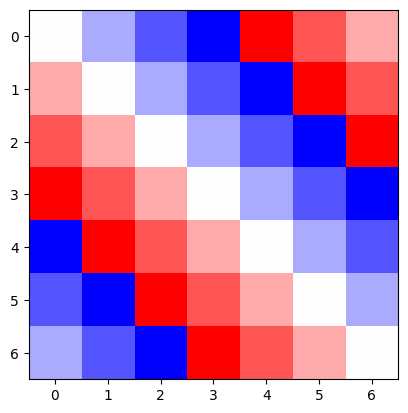

In [3]:
import matplotlib.pyplot as plt
plt.imshow(af_model._inputs["offset"],cmap="bwr")

In [4]:
af_model.restart()
af_model.design_3stage()

Stage 1: running (logits → soft)
1 models [0] recycles 0 hard 0 soft 0.00 temp 1 seqid 0 loss 2.54 dgram_cce 2.54 plddt 0.77 ptm 0.06 rmsd 1.61
2 models [2] recycles 0 hard 0 soft 0.01 temp 1 seqid 0 loss 2.49 dgram_cce 2.49 plddt 0.71 ptm 0.06 rmsd 1.64
3 models [2] recycles 0 hard 0 soft 0.01 temp 1 seqid 0 loss 2.33 dgram_cce 2.33 plddt 0.73 ptm 0.06 rmsd 1.66
4 models [0] recycles 0 hard 0 soft 0.01 temp 1 seqid 0.14 loss 2.87 dgram_cce 2.87 plddt 0.62 ptm 0.05 rmsd 1.52
5 models [0] recycles 0 hard 0 soft 0.02 temp 1 seqid 0 loss 2.33 dgram_cce 2.33 plddt 0.83 ptm 0.06 rmsd 1.15
6 models [0] recycles 0 hard 0 soft 0.02 temp 1 seqid 0 loss 2.42 dgram_cce 2.42 plddt 0.77 ptm 0.06 rmsd 1.36
7 models [0] recycles 0 hard 0 soft 0.02 temp 1 seqid 0 loss 2.48 dgram_cce 2.48 plddt 0.80 ptm 0.06 rmsd 0.68
8 models [2] recycles 0 hard 0 soft 0.03 temp 1 seqid 0.14 loss 2.48 dgram_cce 2.48 plddt 0.75 ptm 0.06 rmsd 1.25
9 models [0] recycles 0 hard 0 soft 0.03 temp 1 seqid 0.14 loss 2.53 dgra

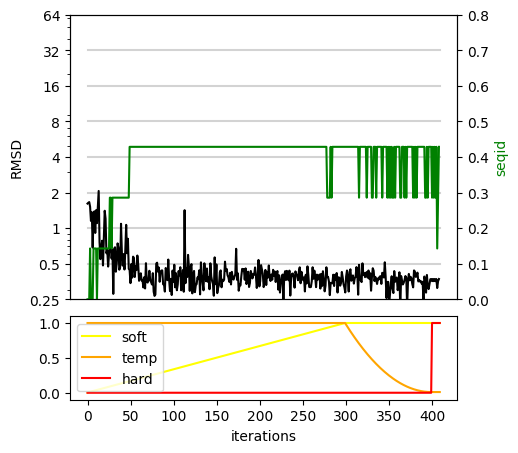

In [5]:
af_model.plot_traj()

In [6]:
af_model.save_pdb(f"{af_model.protocol}.pdb")
af_model.plot_pdb(show_mainchains=True)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [7]:
HTML(af_model.animate())

In [8]:
af_model.get_seqs()

['GEPGSPD']

# hallucination (~1 minute)
For a given length, generate/hallucinate a protein sequence that AlphaFold thinks folds into a well structured protein (high plddt, low pae, many contacts).

In [9]:
clear_mem()
af_model = mk_afdesign_model(protocol="hallucination")
af_model.prep_inputs(length=13, rm_aa="C")
add_cyclic_offset(af_model)
# add_rg_loss(af_model)

print("length",af_model._len)
print("weights",af_model.opt["weights"])

length 13
weights {'con': 1.0, 'exp_res': 0.0, 'helix': 0.0, 'pae': 0.0, 'plddt': 0.0, 'seq_ent': 0.0}


In [10]:
# pre-design with gumbel initialization and softmax activation
af_model.restart()
af_model.set_seq(mode="gumbel")
af_model.set_opt("con", binary=True, cutoff=21.6875, num=af_model._len, seqsep=0)
af_model.set_weights(pae=1, plddt=1, con=0.5)
af_model.design_soft(50)

# three stage design
af_model.set_seq(seq=af_model.aux["seq"]["pseudo"])
af_model.design_3stage(50,50,10)

1 models [3] recycles 0 hard 0 soft 1 temp 1 loss 0.55 pae 0.23 con 0.00 plddt 0.67 ptm 0.03
2 models [1] recycles 0 hard 0 soft 1 temp 1 loss 0.63 pae 0.22 con 0.00 plddt 0.58 ptm 0.03
3 models [3] recycles 0 hard 0 soft 1 temp 1 loss 0.55 pae 0.22 con 0.00 plddt 0.67 ptm 0.03
4 models [2] recycles 0 hard 0 soft 1 temp 1 loss 0.54 pae 0.21 con 0.00 plddt 0.67 ptm 0.03
5 models [4] recycles 0 hard 0 soft 1 temp 1 loss 0.55 pae 0.20 con 0.00 plddt 0.65 ptm 0.03
6 models [4] recycles 0 hard 0 soft 1 temp 1 loss 0.56 pae 0.21 con 0.00 plddt 0.65 ptm 0.03
7 models [3] recycles 0 hard 0 soft 1 temp 1 loss 0.51 pae 0.21 con 0.00 plddt 0.70 ptm 0.03
8 models [2] recycles 0 hard 0 soft 1 temp 1 loss 0.52 pae 0.20 con 0.00 plddt 0.68 ptm 0.03
9 models [4] recycles 0 hard 0 soft 1 temp 1 loss 0.52 pae 0.20 con 0.00 plddt 0.69 ptm 0.03
10 models [4] recycles 0 hard 0 soft 1 temp 1 loss 0.50 pae 0.21 con 0.00 plddt 0.70 ptm 0.03
11 models [0] recycles 0 hard 0 soft 1 temp 1 loss 0.58 pae 0.22 con 

In [11]:
af_model.save_pdb(f"{af_model.protocol}.pdb")
af_model.plot_pdb(show_mainchains=True)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [12]:
HTML(af_model.animate())

In [13]:
af_model.get_seqs()

['PPEECKITCRPNA']